# Navigation


### 1. Start the Environment

Import necessary packages

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="/Applications/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training Method

The method below will train all agents in this project. It uses Q-learning with epsilon-greedy policy. Epsilon decays by the end of training to improve convergence.

The method saves the agent configuration, which produces the highest average score over 100 consecutive episodes, to a file.

In [6]:
def train(
    agent,
    file_name,
    n_episodes=1000,
    max_t=1000,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay=0.995):

    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    max_mean_score = 0
    save_model_dict = None
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        mean_score = np.mean(scores_window)

        print('\rEpisode {}\tAverage Score: {:.2f} '.format(
            i_episode,
            mean_score), end="")

        if i_episode % 100 == 0:

            print('\rEpisode {}\tAverage Score: {:.2f} '.format(
                i_episode,
                mean_score))
            
        if max_mean_score < mean_score:
            max_mean_score = mean_score
            save_model_dict = agent.qnetwork_local.state_dict().copy()
            
    print()
    
    if save_model_dict is not None:
        print("Saving network with score {:.2f} to".format(max_mean_score), file_name)
        torch.save(save_model_dict, file_name)    
            
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return

### 4. Testing Method

Define ```test()``` method to validate and demonstrate training results. It replays the agent 100 times in the environment in a training mode to calculate and output the average score.

Then it runs the agent in the environment in a testing mode once again for demonstration and outputs the last score.

In [7]:
def test_one_episode(env_info, agent):
    """Test one episode of the agent in env_info environment. Return the total score obtained
    
    Params
    ======
        env_info: Unity environment episode
        agent: the trained agent to test
    """

    state = env_info.vector_observations[0] 

    score = 0
    
    for j in range(1000):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        score += reward
        done = env_info.local_done[0]
        if done:
            break
            
    return score
    

def test(agent, file_name):
    """Test the agent, which configuration is stored in a file. Output test statistics
    
    Params
    ======
        agent: Agent instance to test
        file_name: File name to load agent configuration from
    """
    
    agent.qnetwork_local.load_state_dict(torch.load(file_name))
    
    scores = []    
    for attempts in range(100):
        env_info = env.reset(train_mode=True)[brain_name]
        score = test_one_episode(env_info, agent)
        scores.append(score)
    
    env_info = env.reset(train_mode=False)[brain_name]
    last_score = test_one_episode(env_info, agent)
        
    print("Average Score: {}".format(np.mean(scores)))
    print("Last Score: {}".format(last_score))

### 5. Vanilla Deep Q-Network Implementation

Deep Q Network, which evaluates Q-values for each action for the given state vector

In [8]:
class VanillaQNetwork(nn.Module):
    """Vanilla Actor Neural Net Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed to reproduce results
        """
        super(VanillaQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


Common training hyperparameters to be used by all agents of this project

In [8]:
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

A named tuple to hold agent experiences, and a helper method to unpack experiences from a list of tuples into torch tensors for training

In [9]:
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "next_state", "done"])


def experience_to_torch_device(experiences):
    """Returns torch.Tensor-s filled with components of Experience list
    
    Params
    ======
        experiences (list of Experience): agent experience stored in Experience tuples
    """
    
    states = torch.from_numpy(np.vstack(
        [e.state for e in experiences if e is not None])).float().to(device)

    actions = torch.from_numpy(np.vstack(
        [e.action for e in experiences if e is not None])).long().to(device)

    rewards = torch.from_numpy(np.vstack(
        [e.reward for e in experiences if e is not None])).float().to(device)

    next_states = torch.from_numpy(np.vstack(
        [e.next_state for e in experiences if e is not None])).float().to(device)

    dones = torch.from_numpy(np.vstack(
        [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, rewards, next_states, dones)

Memory buffer to replay experiences in a random order for more efficient neural network training

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        
        random.seed(seed)

        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

        
    def sample(self, calc_loss):
        """Randomly sample a batch of experiences from memory, pass them to calc_loss() and return
        loss value from calc_loss() method."""
        experiences = random.sample(self.memory, k=self.batch_size)

        state, action, reward, next_state, done = \
            experience_to_torch_device(experiences)

        return calc_loss(state, action, reward, next_state, done)


    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Basic implementation of Deep Q Network agent, described in http://files.davidqiu.com//research/nature14236.pdf

In [11]:
class VanillaAgent():
    """Basic DQN agent that interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        # Q-Network
        self.qnetwork_local = self._createNetwork()
        self.qnetwork_target = self._createNetwork()
        self.optimizer_local = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.optimizer_target = optim.Adam(self.qnetwork_target.parameters(), lr=LR)
        
        # Replay memory
        self.memory = self._createMemory()
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        
    def step(self, state, action, reward, next_state, done):
        """Perform a training step"""
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                self.learn()
                
                
    def act(self, state, eps=0.01):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection           
        """
        
        # eps=0.01 by default to enable epsilon-greedy policy even at testing.
        # This avoids dead-locks when the agent cannot decide which banana to pick
        # or how to avoid an obstacle, jumping back and forth between two choices
        # forever
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self._calc_action_values(state, self.qnetwork_local)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

                
    def learn(self):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        loss = self.memory.sample(self._calc_loss).mean()
        
        self.optimizer_local.zero_grad()
        loss.backward()      
        self.optimizer_local.step()
      
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in \
            zip(target_model.parameters(), local_model.parameters()):

            target_param.data.copy_(
                tau*local_param.data + (1.0-tau)*target_param.data)          
        
        
    def _createNetwork(self):
        """Create a neural network.
        Pseudo-protected method, which can be overriden in the subclass"""

        return VanillaQNetwork(self.state_size, self.action_size, self.seed).to(device)
    
    
    def _createMemory(self):
        """Create a memory experience buffer.
        Pseudo-protected method, which can be overriden in the subclass"""

        return ReplayBuffer(self.action_size, int(1e5), BATCH_SIZE, self.seed)
    
        
    def _calc_action_values(self, state, qnetwork):
        """Return Q-action values for the given state, using qnetwork neural network.
        Pseudo-protected method, which can be overriden in the subclass"""
        
        return qnetwork(state)
        
        
    def _calc_loss(self, states, actions, rewards, next_states, dones):
        """Calculate loss with its gradients for training the neural network.
        Pseudo-protected method, which can be overriden in the subclass"""
        
        with torch.no_grad():
            q_next = self._calc_action_values(next_states, self.qnetwork_target)
            targets = rewards + (1.0 - dones) * GAMMA * q_next.max(1)[0].unsqueeze(1)
        
        outputs = self.qnetwork_local.forward(states).gather(1, actions)                        
        return (targets - outputs)**2

Train the agent. Show training statistics. Pick and save to a file the agent configuration with the maximum average score over 100 episodes

Episode 100	Average Score: 1.41 
Episode 200	Average Score: 5.29 
Episode 300	Average Score: 8.68 
Episode 400	Average Score: 11.15 
Episode 500	Average Score: 13.03 
Episode 600	Average Score: 13.44 
Episode 700	Average Score: 14.72 
Episode 800	Average Score: 15.33 
Episode 900	Average Score: 15.10 
Episode 1000	Average Score: 15.62 

Saving network with score 15.88 to vanilla.pth


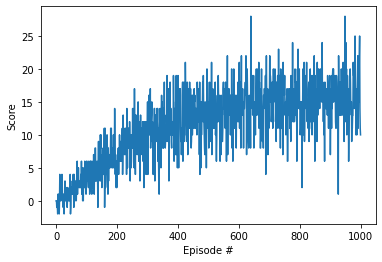

In [12]:
vanilla_agent = VanillaAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=vanilla_agent, file_name="vanilla.pth")

Test the agent. Average score of 100 episodes exceeds 13.0, so the project submission criteria is satisfied.

In [12]:
vanilla_agent = VanillaAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=vanilla_agent, file_name="vanilla.pth")

Average Score: 16.25
Last Score: 15.0


### 6. Double Deep Q-Network

Double Q agent implementation, described in https://arxiv.org/abs/1509.06461

This is the most basic imporvement, as only ```_calc_loss()``` method needs overriding. I tried two versions of the method: with and without gradients for ```q_local```. The former seems to achieve higher score, so I keep it.

In [12]:
class DoubleQAgent(VanillaAgent):
    """DQN agent that is less confident with its Q-values."""
    
    def __init__(self, state_size, action_size, seed):
        super(DoubleQAgent, self).__init__(state_size, action_size, seed)
    

    def _calc_loss(self, states, actions, rewards, next_states, dones):
        q_next = self._calc_action_values(next_states, self.qnetwork_target).detach()
        q_local = self._calc_action_values(next_states, self.qnetwork_local)

        targets = (rewards + (1.0 - dones) * GAMMA
                   * q_next.gather(1, q_local.max(1)[1].unsqueeze(1)))
        
        outputs = self.qnetwork_local.forward(states).gather(1, actions)
        
        return (targets - outputs)**2

The agent initially picks lower scores than VanillaAgent, but finally achieves higher score while training

Episode 100	Average Score: 0.68 
Episode 200	Average Score: 4.08 
Episode 300	Average Score: 7.29 
Episode 400	Average Score: 9.98 
Episode 500	Average Score: 12.33 
Episode 600	Average Score: 13.30 
Episode 700	Average Score: 14.50 
Episode 800	Average Score: 15.12 
Episode 900	Average Score: 15.90 
Episode 1000	Average Score: 16.79 

Saving network with score 16.88 to double_q.pth


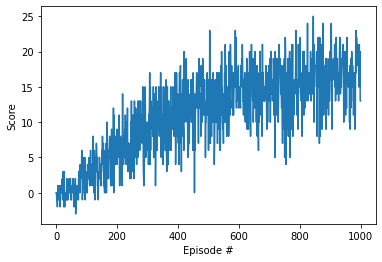

In [13]:
double_q_agent = DoubleQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=double_q_agent, file_name="double_q.pth")

The test results of DoubleQAgent are higher than for VanillaAgent

In [14]:
double_q_agent = DoubleQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=double_q_agent, file_name="double_q.pth")

Average Score: 16.77
Last Score: 21.0


### 7. Dueling Deep Q-Network

In [15]:
class DuelingQNetwork(nn.Module):
    """Vanilla Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3_a = nn.Linear(64, 8)
        self.fc3_v = nn.Linear(64, 8)
        self.fc4_a = nn.Linear(8, action_size)
        self.fc4_v = nn.Linear(8, 1)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        a = self.fc3_a(x)
        v = self.fc3_v(x)
        a = F.relu(a)
        v = F.relu(v)
        a = self.fc4_a(a)
        v = self.fc4_v(v)
        
        return a + v - torch.mean(a, dim=1).reshape(-1, 1)

In [16]:
class DuelingQAgent(DoubleQAgent):
    def __init__(self, state_size, action_size, seed):
        super(DuelingQAgent, self).__init__(state_size, action_size, seed)
        
        
    def _createNetwork(self):
        return DuelingQNetwork(self.state_size, self.action_size, self.seed).to(device)    

Episode 100	Average Score: 0.97 
Episode 200	Average Score: 4.81 
Episode 300	Average Score: 7.88 
Episode 400	Average Score: 10.36 
Episode 500	Average Score: 14.02 
Episode 600	Average Score: 14.99 
Episode 700	Average Score: 15.50 
Episode 800	Average Score: 15.05 
Episode 900	Average Score: 16.37 
Episode 1000	Average Score: 16.47 

Saving network with score 16.95 to dueling_q.pth


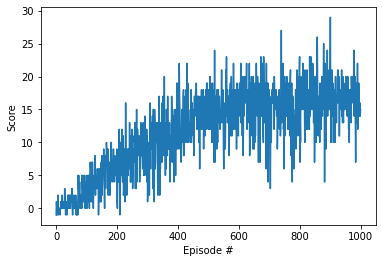

In [17]:
dueling_q_agent = DuelingQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=dueling_q_agent, file_name="dueling_q.pth")

In [17]:
dueling_q_agent = DuelingQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=dueling_q_agent, file_name="dueling_q.pth")

Average Score: 16.02
Last Score: 18.0


### 8. Prioritized Replay

In [18]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        super(PrioritizedReplayBuffer, self).__init__(
            action_size,
            buffer_size,
            batch_size,
            seed)
        
        self.priorities = deque(maxlen=buffer_size)
        self.beta = 0.4
        self.sample_idx = 0
        np.random.seed(seed)
        
        
    def add(self, state, action, reward, next_state, done):
        super(PrioritizedReplayBuffer, self).add(state, action, reward, next_state, done)

        self.priorities.append(max(self.priorities, default=1.0))

        self.sample_idx += 1
        self.beta = 0.4 + min(1.0, self.sample_idx / 1e5) * (1.0 - 0.4)

        
    def sample(self, calc_loss):
        """Randomly sample a batch of experiences from memory."""
        
        memory_size = len(self.memory)
        
        probabilities = np.array(self.priorities)
        probabilities /= probabilities.sum()
        
        selected_indices = np.random.choice(
            memory_size,
            size=self.batch_size,
            p=probabilities,
            replace=False)
        
        experience = [self.memory[i] for i in selected_indices]
        states, actions, rewards, next_states, dones = experience_to_torch_device(experience)
        
        selected_probabilities = probabilities[selected_indices]
        weights = (memory_size * selected_probabilities) ** -self.beta
        weights /= weights.max()       
        weights = torch.Tensor(weights).to(device).unsqueeze(1)
       
        loss = calc_loss(states, actions, rewards, next_states, dones)
        
        with torch.no_grad():       
            new_probabilities = loss + 0.01
            new_probabilities.pow_(0.6)
            new_probabilities = new_probabilities.cpu().numpy().reshape(-1)
        
        for i in range(len(new_probabilities)):
            self.priorities[selected_indices[i]] = new_probabilities[i]
        
        return loss * weights

In [19]:
class PrioritizedReplayQAgent(DuelingQAgent):
    def __init__(self, state_size, action_size, seed):
        super(PrioritizedReplayQAgent, self).__init__(state_size, action_size, seed)
        
    
    def _createMemory(self):
        return PrioritizedReplayBuffer(self.action_size, int(1e5), BATCH_SIZE, self.seed)

Episode 100	Average Score: 0.78 
Episode 200	Average Score: 3.20 
Episode 300	Average Score: 5.67 
Episode 400	Average Score: 10.20 
Episode 500	Average Score: 12.84 
Episode 600	Average Score: 14.68 
Episode 700	Average Score: 14.56 
Episode 800	Average Score: 14.76 
Episode 900	Average Score: 16.48 
Episode 1000	Average Score: 17.38 

Saving network with score 17.55 to prioritized_replay.pth


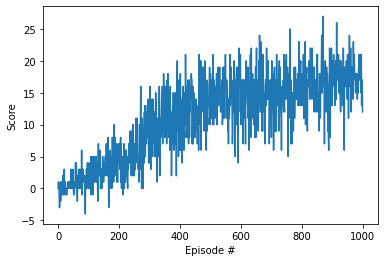

In [17]:
prioritized_replay_q_agent = PrioritizedReplayQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(
    agent=prioritized_replay_q_agent,
    file_name="prioritized_replay.pth")

In [20]:
prioritized_replay_q_agent = PrioritizedReplayQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(
    agent=prioritized_replay_q_agent,
    file_name="prioritized_replay.pth")

Average Score: 17.14
Last Score: 14.0


### 9. Distributed Q-Value Estimation

In [21]:
class DistributedDuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, n_atoms):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            n_atoms (int): Number of Zi atoms for distributed representation of Q value
        """
        super(DistributedDuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.n_atoms = n_atoms

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3_a = nn.Linear(64, 64)
        self.fc3_v = nn.Linear(64, 64)
        self.fc4_a = nn.Linear(64, action_size * n_atoms)
        self.fc4_v = nn.Linear(64, n_atoms)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        a = self.fc3_a(x)
        v = self.fc3_v(x)
        a = F.relu(a)
        v = F.relu(v)
        a = self.fc4_a(a).reshape(-1, self.n_atoms, self.action_size)
        v = self.fc4_v(v).reshape(-1, self.n_atoms, 1)
        
        return a + v - torch.mean(a, dim=2).reshape(-1, self.n_atoms, 1)

In [22]:
class DistributedQValueAgent(PrioritizedReplayQAgent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        self.n_atoms = 129
        super(DistributedQValueAgent, self).__init__(state_size, action_size, seed)

        self.v_min = -32.0
        self.v_max = 32.0
        
        numpy_atoms = np.linspace(self.v_min,  self.v_max, self.n_atoms)
        numpy_atoms = numpy_atoms.reshape(1, -1, 1)
        self.atoms = torch.Tensor(numpy_atoms).to(device)
        self.delta_z = (self.v_max - self.v_min) / (self.n_atoms - 1.0)
        
        
    def _createNetwork(self):
        return DistributedDuelingQNetwork(
            self.state_size,
            self.action_size,
            self.seed,
            self.n_atoms).to(device)
               
        
    def _calc_action_values(self, state, qnetwork):
        action_atom_probs = self.__calc_action_probs(state, qnetwork)
        action_values = (action_atom_probs * self.atoms).sum(dim=1)
        return action_values.reshape(-1, self.action_size)
    
    
    def __calc_action_probs(self, state, qnetwork):
        action_atom_log_probs = qnetwork(state)
        return F.softmax(action_atom_log_probs, dim=1)
        
        
    def _calc_loss(self, states, actions, rewards, next_states, dones):

        local_action_values = self._calc_action_values(next_states, self.qnetwork_local)
        local_max_actions = local_action_values.max(1)[1]

        local_max_atom_actions = local_max_actions.reshape(-1, 1, 1).repeat(
            1,
            self.n_atoms,
            1)

        target_action_probs = self.__calc_action_probs(next_states, self.qnetwork_target)
        target_action_probs = target_action_probs.detach()

        next_action_probs = target_action_probs.gather(2, local_max_atom_actions).squeeze()

        atom_probs = torch.zeros(states.size()[0], self.n_atoms).to(device)

        for i in range(self.n_atoms):
            tz = rewards + (1.0 - dones) * GAMMA * self.atoms[0, i, 0]
            tz.clamp_(self.v_min, self.v_max)

            b = (tz - self.v_min) / self.delta_z
            low = b
            high = (b + 0.5)

            low_long = low.long()
            high_long = high.long()

            # Round to nearest integer
            low = low_long.float()
            high = high_long.float()

            next_action_atom_probs = next_action_probs[:, i].unsqueeze(1)

            low_atom_probs = atom_probs.gather(1, low_long)
            low_atom_probs += next_action_atom_probs * (high - b)
            atom_probs.scatter_(1, low_long, low_atom_probs)

            high_atom_probs = atom_probs.gather(1, high_long)
            high_atom_probs += next_action_atom_probs * (b - low)
            atom_probs.scatter_(1, high_long, high_atom_probs)
                    
        atom_actions = actions.reshape(-1, 1, 1).repeat(1, self.n_atoms, 1)
        outputs = self.qnetwork_local.forward(states).gather(2, atom_actions)
        outputs = outputs.squeeze()

        return -(atom_probs * F.log_softmax(outputs, dim=1)).sum(dim=1)

In [23]:
# Since this is getting complicated, I decided to make sure calculations
# work as intended

import unittest


class TestDistributedDuelingQNetwork(unittest.TestCase):

    def test_forward_shape_batch(self):
        state_size = 3
        action_size = 2
        n_atoms = 5
        batch_size = 12
        
        network = DistributedDuelingQNetwork(
            state_size=state_size,
            action_size=action_size,
            seed=0,
            n_atoms=n_atoms).to(device)
        
        output = network.forward(torch.zeros(batch_size, state_size).to(device))
        
        self.assertEqual(3, len(output.size()))
        self.assertEqual(batch_size, output.size()[0])
        self.assertEqual(n_atoms, output.size()[1])
        self.assertEqual(action_size, output.size()[2])

        
class TestDistributedQValueAgent(unittest.TestCase):
    
    def test_init(self):
        state_size = 3
        action_size = 2
            
        agent = DistributedQValueAgent(
            state_size=state_size,
            action_size=action_size,
            seed=0)
        
        atoms = agent.atoms.cpu().numpy()
        
        self.assertEqual(1, agent.atoms.size()[0])
        self.assertEqual(agent.n_atoms, agent.atoms.size()[1])
        self.assertEqual(1, agent.atoms.size()[2])
        self.assertAlmostEqual(agent.delta_z, atoms[0, 1, 0] - atoms[0, 0, 0], places=5)
        
    
    def test_calc_action_values(self):
        state_size = 2
        action_size = 3
            
        agent = DistributedQValueAgent(
            state_size=state_size,
            action_size=action_size,
            seed=0)
        
        state = torch.zeros(BATCH_SIZE, state_size).to(device)

        action_values = agent._calc_action_values(state, agent.qnetwork_local)
        
        self.assertEqual(2, len(action_values.size()))
        self.assertEqual(BATCH_SIZE, action_values.size()[0])
        self.assertEqual(action_size, action_values.size()[1])
        
        
    def test_calc_loss(self):
        state_size = 4
        action_size = 6
            
        agent = DistributedQValueAgent(
            state_size=state_size,
            action_size=action_size,
            seed=0)
        
        states = torch.zeros(BATCH_SIZE, state_size).to(device)
        actions = torch.zeros(BATCH_SIZE, 1).long().to(device)
        rewards = torch.zeros(BATCH_SIZE, 1).to(device)
        next_states = torch.zeros(BATCH_SIZE, state_size).to(device)
        dones = torch.zeros(BATCH_SIZE, 1).to(device)
        
        residuals = agent._calc_loss(states, actions, rewards, next_states, dones)
        self.assertEqual(1, len(residuals.size()))
        self.assertEqual(BATCH_SIZE, residuals.size()[0])
        
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_forward_shape_batch (__main__.TestDistributedDuelingQNetwork) ... ok
test_calc_action_values (__main__.TestDistributedQValueAgent) ... ok
test_calc_loss (__main__.TestDistributedQValueAgent) ... ok
test_init (__main__.TestDistributedQValueAgent) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.038s

OK


Episode 100	Average Score: 0.04 
Episode 200	Average Score: 2.01 
Episode 300	Average Score: 4.96 
Episode 400	Average Score: 9.04 
Episode 500	Average Score: 12.25 
Episode 600	Average Score: 15.25 
Episode 700	Average Score: 15.59 
Episode 800	Average Score: 16.03 
Episode 900	Average Score: 15.95 
Episode 1000	Average Score: 16.61 

Saving network with score 16.61 to distributed_q_value.pth


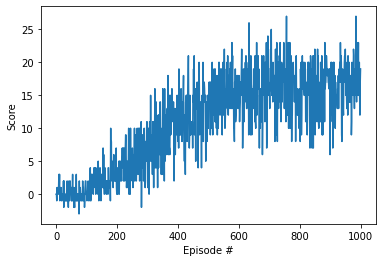

In [22]:
distributed_q_value_agent = DistributedQValueAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(
    agent=distributed_q_value_agent,
    file_name="distributed_q_value.pth")

In [24]:
distributed_q_value_agent = DistributedQValueAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(
    agent=distributed_q_value_agent,
    file_name="distributed_q_value.pth")

Average Score: 18.75
Last Score: 18.0


### 10. Noisy Network

In [25]:
from torch.autograd import Variable
import math

# Borrowed form https://github.com/Shmuma/ptan/blob/master/samples/rainbow/lib/dqn_model.py
class NoisyFactorizedLinear(nn.Linear):
    """
    NoisyNet layer with factorized gaussian noise
    N.B. nn.Linear already initializes weight and bias to
    """
    def __init__(self, in_features, out_features, sigma_zero=0.4):
        super(NoisyFactorizedLinear, self).__init__(in_features, out_features, bias=True)
        sigma_init = sigma_zero / math.sqrt(in_features)

        self.sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features).fill_(sigma_init))

        self.register_buffer("epsilon_input", torch.zeros(1, in_features))
        self.register_buffer("epsilon_output", torch.zeros(out_features, 1))
        self.sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(sigma_init))

            
    def forward(self, input):
        torch.randn(self.epsilon_input.size(), out=self.epsilon_input)
        torch.randn(self.epsilon_output.size(), out=self.epsilon_output)

        func = lambda x: torch.sign(x) * torch.sqrt(torch.abs(x))
        eps_in = func(self.epsilon_input)
        eps_out = func(self.epsilon_output)

        bias = self.bias + self.sigma_bias * Variable(eps_out.t())
        noise_v = Variable(torch.mul(eps_in, eps_out))
        return F.linear(input, self.weight + self.sigma_weight * noise_v, bias)


class NoisyDistributedDuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, n_atoms):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            n_atoms (int): Number of Zi atoms for distributed representation of Q value
        """
        super(NoisyDistributedDuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.n_atoms = n_atoms

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3_a = NoisyFactorizedLinear(64, 64)
        self.fc3_v = NoisyFactorizedLinear(64, 64)
        self.fc4_a = nn.Linear(64, action_size * n_atoms)
        self.fc4_v = nn.Linear(64, n_atoms)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        a = self.fc3_a(x)
        v = self.fc3_v(x)
        a = F.relu(a)
        v = F.relu(v)
        a = self.fc4_a(a).reshape(-1, self.n_atoms, self.action_size)
        v = self.fc4_v(v).reshape(-1, self.n_atoms, 1)
        
        return a + v - torch.mean(a, dim=2).reshape(-1, self.n_atoms, 1)

In [26]:
class NoisyDistributedQValueAgent(DistributedQValueAgent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        super(NoisyDistributedQValueAgent, self).__init__(state_size, action_size, seed)

        
    def _createNetwork(self):
        return NoisyDistributedDuelingQNetwork(
            self.state_size,
            self.action_size,
            self.seed,
            self.n_atoms).to(device)
        
        
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self._calc_action_values(state, self.qnetwork_local)        
        self.qnetwork_local.train()

        # Randomness is built in the neural network
        return np.argmax(action_values.cpu().data.numpy())

Episode 100	Average Score: -0.02 
Episode 200	Average Score: 0.91  
Episode 300	Average Score: 7.24 
Episode 400	Average Score: 9.30 
Episode 500	Average Score: 10.45 
Episode 600	Average Score: 12.05 
Episode 700	Average Score: 14.18 
Episode 800	Average Score: 13.64 
Episode 900	Average Score: 15.74 
Episode 1000	Average Score: 16.49 

Saving network with score 16.80 to noisy_distributed_q_value.pth


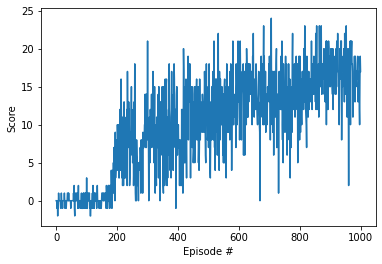

In [26]:
noisy_distributed_q_value_agent = NoisyDistributedQValueAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(
    agent=noisy_distributed_q_value_agent,
    file_name="noisy_distributed_q_value.pth")

In [27]:
noisy_distributed_q_value_agent = NoisyDistributedQValueAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(
    agent=noisy_distributed_q_value_agent,
    file_name="noisy_distributed_q_value.pth")

Average Score: 16.92
Last Score: 18.0


### 11. Conclusions

In [28]:
env.close()